# Exploratory Data Analysis - Renthop dataset

This notebook contains 3 parts: 
1. **Exploring numerical features**
2. **Exploring manager_id (High Cardinality Data)**
3. **Exploring geographical features**

In [80]:
# import libraries
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import random 
from scipy import sparse
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
import time as time
import xgboost as xgb

%matplotlib inline

In [76]:
train_df = pd.read_json("Downloads/Kaggle_TwoSigma_train.json")
test_df = pd.read_json("Downloads/Kaggle_TwoSigma_test.json")

## 1. Exploring numerical features 

### Checking the target variable "interest_level"

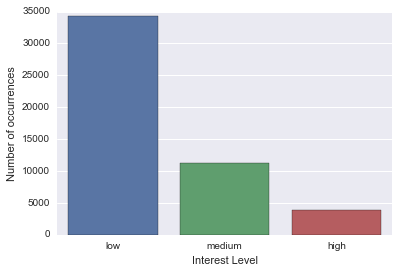

In [4]:
sns.countplot(train_df.interest_level, order=['low', 'medium', 'high'])
plt.xlabel('Interest Level')
plt.ylabel('Number of occurrences')

In [5]:
print ("Low Interest count {}".format((train_df['interest_level'] == 'low').sum())) 
print ("Medium Interest count {}".format((train_df['interest_level'] == 'medium').sum())) 
print ("High Interest count {}".format((train_df['interest_level'] == 'high').sum())) 

Low Interest count 34284
Medium Interest count 11229
High Interest count 3839


### Relationship between num of bedrooms and interest level

Dataset does not provide square footage of apartment. Number of bedrooms and bathrooms are probably the closest indicator to floor area. 

Worth trying another time: 
Estimating floor area of each apartment based on number of bedrooms and bathrooms. 

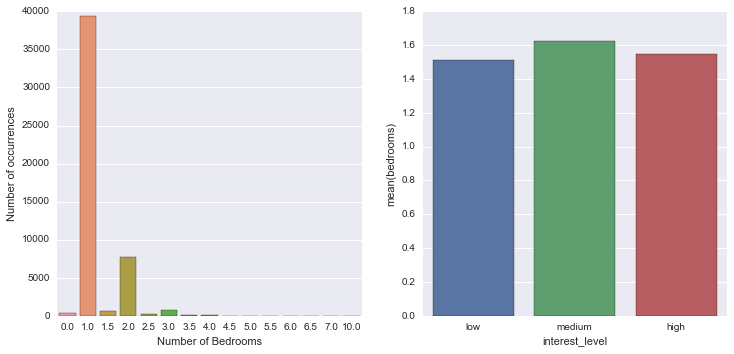

In [6]:
plt.figure(figsize=(12,12))
plt.title('Number of Bedrooms in relation to Interest Level', fontsize=14)
sns.countplot(train_df.bathrooms, ax = plt.subplot(221))
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of occurrences')
### Average number of Bathrooms per Interest Level
sns.barplot(x='interest_level', y='bedrooms', data=train_df, order=['low', 'medium', 'high'],
            ax = plt.subplot(222), ci=None)

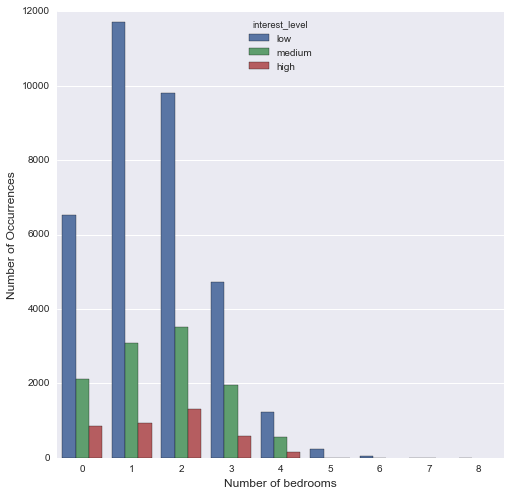

In [10]:
plt.figure(figsize=(8,8))
sns.countplot(x='bedrooms', hue='interest_level', hue_order=['low', 'medium', 'high'], data=train_df)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of bedrooms', fontsize=12)

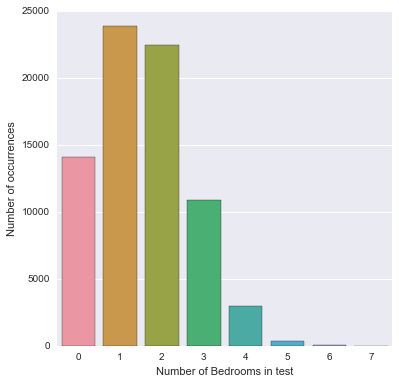

In [18]:
# check test for outliers - none
plt.figure(figsize=(6,6))
sns.countplot(test_df.bedrooms)
plt.xlabel('Number of Bedrooms in test')
plt.ylabel('Number of occurrences')

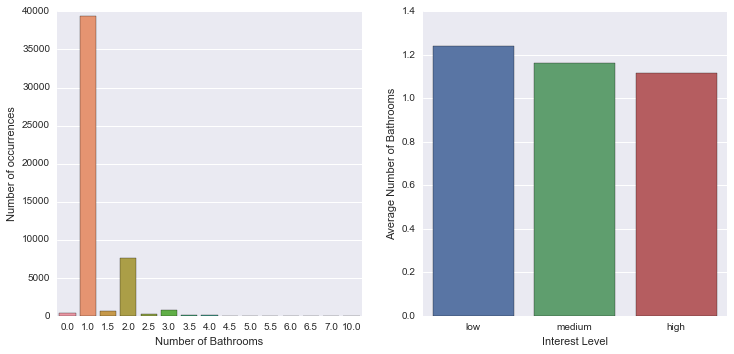

In [11]:
fig = plt.figure(figsize=(12,12))
sns.countplot(train_df.bathrooms, ax = plt.subplot(221))
plt.xlabel('Number of Bathrooms')
plt.ylabel('Number of occurrences')
sns.barplot(x='interest_level', y='bathrooms', data=train_df, order=['low', 'medium', 'high'],
            ax = plt.subplot(222), ci=None)
plt.xlabel('Interest Level')
plt.ylabel('Average Number of Bathrooms')

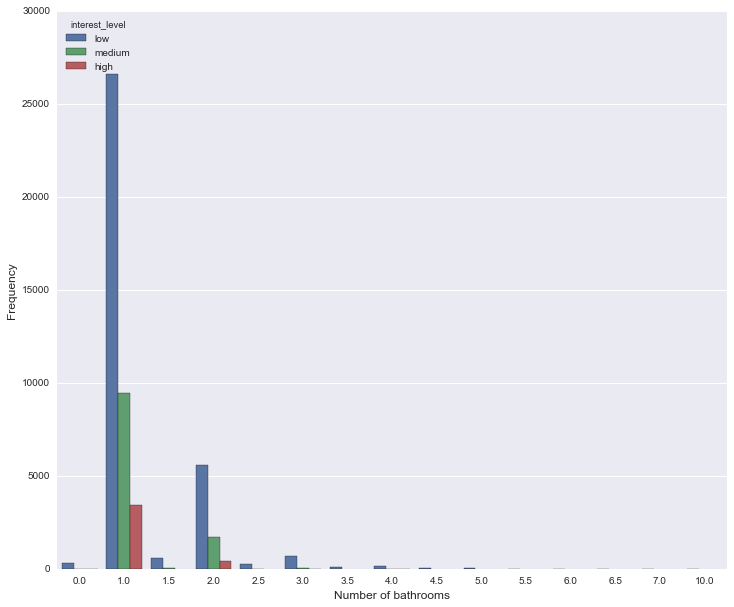

In [21]:
plt.figure(figsize=(12,10))
sns.countplot(x='bathrooms', hue='interest_level', hue_order = ['low', 'medium', 'high'], data=train_df)
plt.ylabel('Frequency', fontsize = 12)
plt.xlabel('Number of bathrooms', fontsize=12)

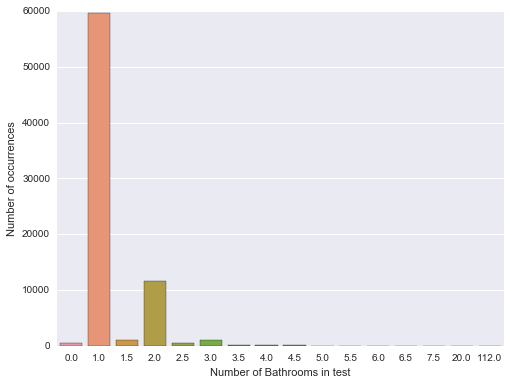

In [19]:
# check outliers in test set
# graph indicates outliers in test set (20 bathrooms and 112 bathrooms) 
# solution used: replace with median 

plt.figure(figsize=(8,6))
sns.countplot(test_df.bathrooms)
plt.xlabel('Number of Bathrooms in test')
plt.ylabel('Number of occurrences')

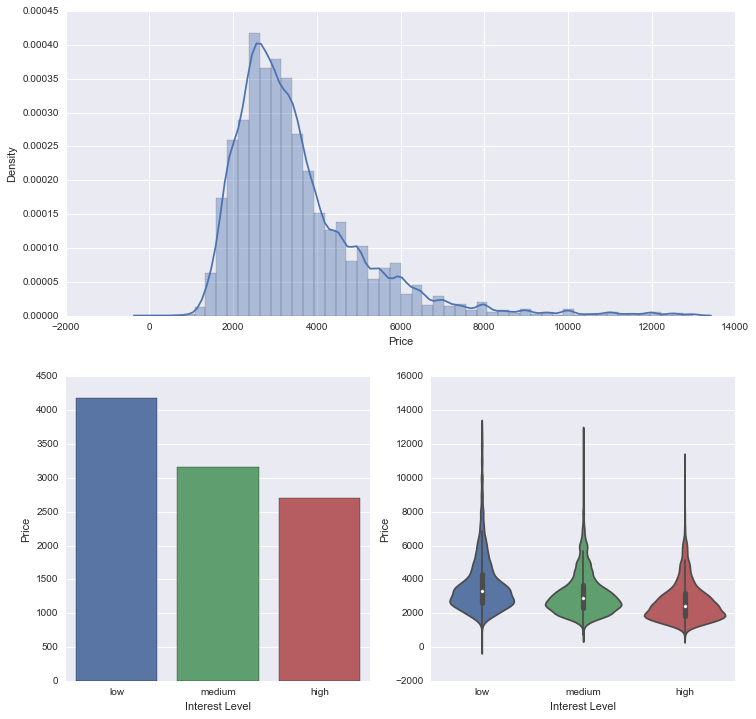

In [20]:
# Price - distribution
# removed outlier by quantile()

fig = plt.figure(figsize=(12,12))
sns.distplot(train_df.price[train_df.price<=train_df.price.quantile(0.99)], 
             ax=plt.subplot(211))
plt.xlabel('Price')
plt.ylabel('Density')
# Average by interest level
sns.barplot(x="interest_level", y="price", order=['low', 'medium', 'high'],
            data=train_df, ax=plt.subplot(223), ci=None)
plt.xlabel('Interest Level')
plt.ylabel('Price')
# violinplots
sns.violinplot(x="interest_level", y="price", order=['low', 'medium', 'high'],
               data=train_df[train_df.price<=train_df.price.quantile(0.99)],
               ax=plt.subplot(224), ci=None)
plt.xlabel('Interest Level')
plt.ylabel('Price')

In [71]:
# Explore variables Price / bedrooms, Price / (bedrooms + bathrooms)
price_t = train_df['price']/train_df['bedrooms']
price_per_room = train_df['price']/(train_df['bathrooms']+ train_df['bedrooms'])

# replace infinity with median - due to occurrence of bedroom = 0 or bathroom = 0
price_t = price_t.replace([np.inf, -np.inf], price_t.median())
price_per_room = price_per_room.replace([np.inf, -np.inf], price_per_room.median())

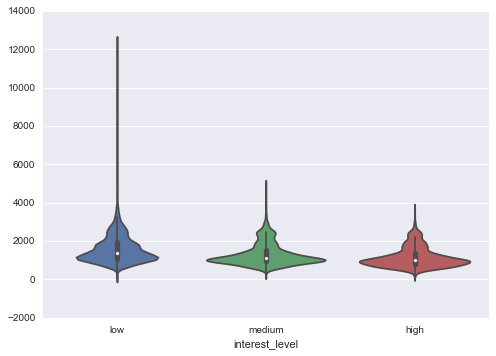

In [86]:
sns.violinplot(x="interest_level" , y = price_t, order=['low', 'medium', 'high'], 
               data=train_df[train_df.price<=train_df.price.quantile(0.99)],
               ci=None)

## 2. Exploring manager_id (High Cardinality Data)

- First we check **manager_id** column and see that there are **3481 unique values** there. 
- Count the number of listings by **manager_id**, and whether those listings belong to "high", "medium", or "low" interest. Cast as dataframe. 
- Sort dataframe by number of listings (regardless of interest) and by number of high interest level listings, and see that some manager_ids can be very informative in interest levels. 

I also explored creating a Manager Skill feature. 

In [47]:
#check unique values in manager_id column
train_df["manager_id"].describe()

count                                49352
unique                                3481
top       e6472c7237327dd3903b3d6f6a94515a
freq                                  2533
Name: manager_id, dtype: object

In [58]:
managerDF = train_df.groupby(['manager_id', 'interest_level'])['manager_id'].count().unstack('interest_level').fillna(0)
managerDF["sum"]=managerDF.sum(axis=1)
managerDF.head()

interest_level,high,low,medium,sum
manager_id,,,,
0000abd7518b94c35a90d64b56fbf3e6,0.0,4.0,8.0,12.0
001ce808ce1720e24a9510e014c69707,0.0,10.0,0.0,10.0
003fc4e9a70053082f131b1054966aaf,0.0,1.0,0.0,1.0
00607a02f6efd9c6c7c588826e471ee9,0.0,0.0,2.0,2.0
00995ff28d79127ed2dca8320e9e7d09,0.0,2.0,1.0,3.0


In [59]:
# sort by number of listings ("sum")
managerDF_sortby_sum = managerDF.sort_values(by="sum", ascending=0)
managerDF_sortby_sum.head(10)

interest_level,high,low,medium,sum
manager_id,,,,
e6472c7237327dd3903b3d6f6a94515a,172.0,1739.0,622.0,2533.0
6e5c10246156ae5bdcd9b487ca99d96a,4.0,644.0,63.0,711.0
8f5a9c893f6d602f4953fcc0b8e6e9b4,1.0,405.0,4.0,410.0
62b685cc0d876c3a1a51d63a0d6a8082,0.0,402.0,0.0,402.0
cb87dadbca78fad02b388dc9e8f25a5b,55.0,135.0,183.0,373.0
9df32cb8dda19d3222d66e69e258616b,14.0,273.0,43.0,330.0
b7de4cb395920136663132057fa89d84,0.0,316.0,4.0,320.0
2aa9bfa5f67ed9997ea341dee8a3a271,38.0,163.0,115.0,316.0
ad3d8ddc52c7e0859b5c6c7f7949c3bd,1.0,280.0,24.0,305.0


We see that a prolific manager has posted 2533 listings. Next, let's specifically look at managers with "high" interest level listings. 

In [60]:
# sort by high interest level
managerDF_sortby_high = managerDF.sort_values(by="high", ascending=0)
managerDF_sortby_high.head(10)

interest_level,high,low,medium,sum
manager_id,,,,
e6472c7237327dd3903b3d6f6a94515a,172.0,1739.0,622.0,2533.0
1fb46c4a72bcf764ac35fc23f394760d,68.0,101.0,120.0,289.0
cb87dadbca78fad02b388dc9e8f25a5b,55.0,135.0,183.0,373.0
12c0a30e296faa0dfd422fe918d7d4f4,51.0,12.0,28.0,91.0
be1a7235af23dd77d0d1029dd5bfa5e9,43.0,10.0,38.0,91.0
2aa9bfa5f67ed9997ea341dee8a3a271,38.0,163.0,115.0,316.0
30a7951cfc21240e8c46b2d079d292e5,36.0,56.0,77.0,169.0
eb5a6c4c2eb6f3e2a085c477afd5a815,34.0,49.0,85.0,168.0
2a4e0d2668fde3afa267d312b3a2a9d8,32.0,38.0,71.0,141.0


### A little feature engineering attempt
Creating a new **"Manager Skill"** variable based on the proportion of high, medium and low interest level listing that a manager gets. 

In [61]:
# express the "high", "medium", "low" counts above as fractions
managerDF_fractions = pd.concat([train_df.manager_id,pd.get_dummies(train_df.interest_level)], axis = 1).groupby('manager_id').mean()
managerDF_fractions.columns = ['high_frac','low_frac', 'medium_frac']
managerDF_fractions.head()

,high_frac,low_frac,medium_frac
manager_id,,,
0000abd7518b94c35a90d64b56fbf3e6,0.0,0.333333,0.666667
001ce808ce1720e24a9510e014c69707,0.0,1.000000,0.000000
003fc4e9a70053082f131b1054966aaf,0.0,1.000000,0.000000
00607a02f6efd9c6c7c588826e471ee9,0.0,0.000000,1.000000
00995ff28d79127ed2dca8320e9e7d09,0.0,0.666667,0.333333


In [69]:
# in order to give more weight to high and medium interest listings for each manager, in creating manager_skill
# we will multiple high_frac by 3, medium_frac by 2, and keep low_frac as is. 

managerDF_fractions['manager_skill'] = managerDF_fractions['high_frac']*3 + managerDF_fractions['medium_frac']*2 + managerDF_fractions['low_frac']
managerDF_fractions.head(10)

,high_frac,low_frac,medium_frac,manager_skill
manager_id,,,,
0000abd7518b94c35a90d64b56fbf3e6,0.0,0.333333,0.666667,1.666667
001ce808ce1720e24a9510e014c69707,0.0,1.000000,0.000000,1.000000
003fc4e9a70053082f131b1054966aaf,0.0,1.000000,0.000000,1.000000
00607a02f6efd9c6c7c588826e471ee9,0.0,0.000000,1.000000,2.000000
00995ff28d79127ed2dca8320e9e7d09,0.0,0.666667,0.333333,1.333333
00a8d77892cab18fffaa22a751f1f8eb,0.0,1.000000,0.000000,1.000000
00f0b3346ba8379b26b95be8a19d46b1,0.0,1.000000,0.000000,1.000000
00f526d80353a50a52bbc26919e7ed5a,0.0,1.000000,0.000000,1.000000
01074bb974b125b65fa1b11a64c65135,0.0,1.000000,0.000000,1.000000


When we try to same exploration with **building_id**, it's pretty clear that there are missing values to be removed. 
I tried OneHotEncoder with building_id but settled with only using LabelEncoder for my model due to lower dimensionality. 

In [36]:
buildingDF = train_df.groupby(['building_id', 'interest_level'])['building_id'].count().unstack('interest_level').fillna(0)
buildingDF["sum"]=buildingDF.sum(axis=1)
buildingDF.head()

interest_level,high,low,medium,sum
building_id,,,,
0,195.0,7588.0,503.0,8286.0
00005cb939f9986300d987652c933e15,0.0,1.0,0.0,1.0
00024d77a43f0606f926e2312513845c,2.0,0.0,1.0,3.0
000ae4b7db298401cdae2b0ba1ea8146,0.0,0.0,1.0,1.0
0012f1955391bca600ec301035b97b65,0.0,1.0,0.0,1.0


In [38]:
#remove outlier
x=buildingDF
x = x[x.index != '0']
buildingDF = x

In [41]:
# sort by number of listings ("sum")
buildingDF_sortby_sum = buildingDF.sort_values(by="sum", ascending=0)
buildingDF_sortby_sum.head(10)

interest_level,high,low,medium,sum
building_id,,,,
96274288c84ddd7d5c5d8e425ee75027,21.0,179.0,75.0,275.0
11e1dec9d14b1a9e528386a2504b3afc,18.0,145.0,52.0,215.0
80a120d6bc3aba97f40fee8c2204524b,18.0,125.0,70.0,213.0
bb8658a3e432fb62a440615333376345,26.0,111.0,75.0,212.0
f68bf347f99df026f4faad43cc604048,14.0,116.0,61.0,191.0
c94301249b8c09429d329864d58e5b82,6.0,140.0,21.0,167.0
ce6d18bf3238e668b2bf23f4110b7b67,20.0,92.0,53.0,165.0
57ef86c28a8ae482dc3a3c3af28e8e48,7.0,103.0,49.0,159.0
128d4af0683efc5e1eded8dc8044d5e3,11.0,105.0,37.0,153.0


In [42]:
# sort by number of listings ("sum")
buildingDF_sortby_sum = buildingDF.sort_values(by="high", ascending=0)
buildingDF_sortby_sum.head(10)

interest_level,high,low,medium,sum
building_id,,,,
bb8658a3e432fb62a440615333376345,26.0,111.0,75.0,212.0
5565db9b7cba3603834c4aa6f2950960,25.0,55.0,46.0,126.0
093f64f52a6e43ba5e8f12bec8200554,22.0,58.0,48.0,128.0
96274288c84ddd7d5c5d8e425ee75027,21.0,179.0,75.0,275.0
80911ce8a425daf4989ea8a4bccc41a7,21.0,48.0,43.0,112.0
ce6d18bf3238e668b2bf23f4110b7b67,20.0,92.0,53.0,165.0
80a120d6bc3aba97f40fee8c2204524b,18.0,125.0,70.0,213.0
11e1dec9d14b1a9e528386a2504b3afc,18.0,145.0,52.0,215.0
be6b7c3fdf3f63a2756306f4af7788a6,18.0,20.0,41.0,79.0


## 3. Exploring geographical features

Intuitively, location should be one of the crucial factors in apartment rent prices. The dataset provides us with longitude and latitude coordinates. It was a challenge trying to extracting the most information out of these columns. 

The following section is informed by notebook from [Darnal](https://www.kaggle.com/arnaldcat/two-sigma-connect-rental-listing-inquiries/unsupervised-and-supervised-neighborhood-encoding). 

('Length before removing ouliers', 49352)
('Length after removing ouliers', 46946)


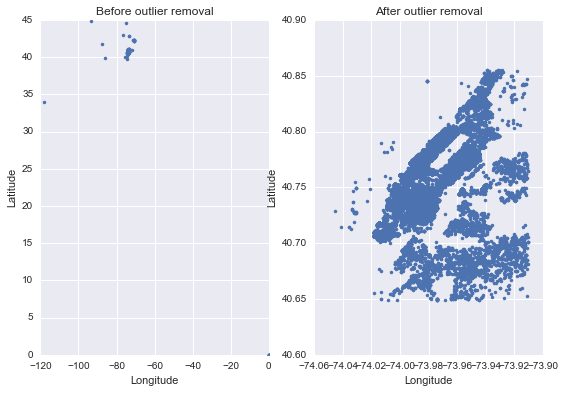

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(9,6))
print('Length before removing ouliers', len(train_df))
ax[0].plot(train_df.longitude, train_df.latitude, '.');
ax[0].set_title('Before outlier removal');
ax[0].set_xlabel('Longitude');
ax[0].set_ylabel('Latitude');
# Outlier removal
for i in ['latitude', 'longitude']:
    while(1):
        x = train_df[i].median()
        ix = abs(train_df[i] - x) > 3*train_df[i].std()
        if ix.sum()==0: # no more outliers -> stop
            break
        train_df.loc[ix, i] = np.nan # exclude outliers
# Keep only non-outlier listings
train_df = train_df.loc[train_df[['latitude', 'longitude']].isnull().sum(1) == 0, :]
print('Length after removing ouliers', len(train_df))
# Show location coordinates after outlier removal
ax[1].plot(train_df.longitude, train_df.latitude, '.');
ax[1].set_title('After outlier removal');
ax[1].set_xlabel('Longitude');
ax[1].set_ylabel('Latitude');

**below** Originally I thought of using k-nearest neighbor or  as one of the prediction models. However, after color-coding interest_level and mapping the listings -- as below -- it became obvious that there was a lot of overlapping clusters of high, medium, low listings. KNN is not an algorithm that deals well with this type of data. 

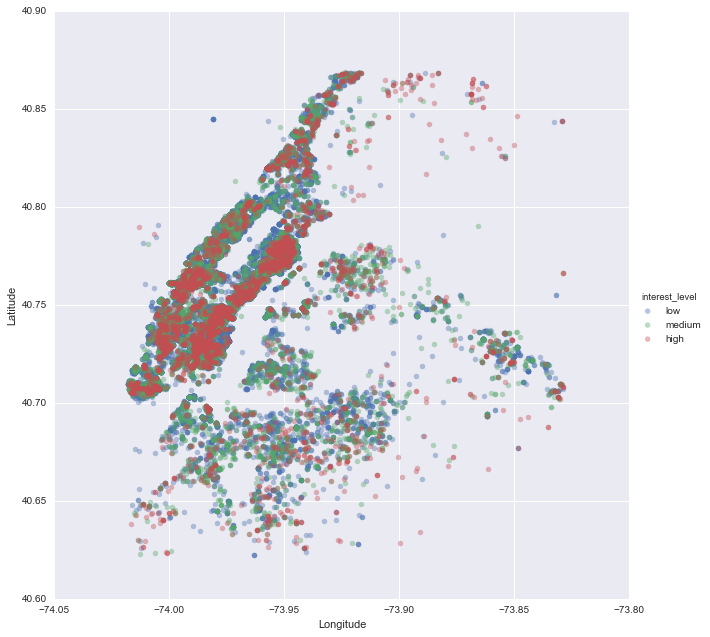

In [109]:
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=9, scatter_kws={'alpha':0.4,'s':30},
           data=train_df[(train_df.longitude>train_df.longitude.quantile(0.005))
                           &(train_df.longitude<train_df.longitude.quantile(0.995))
                           &(train_df.latitude>train_df.latitude.quantile(0.005))                           
                           &(train_df.latitude<train_df.latitude.quantile(0.995))])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [91]:
num_map = {'high':1, 'medium':0.5, 'low':0}
train_df['interest_level'] = train_df['interest_level'].apply(lambda x: num_map[x])

<br>
One possibility is to encode neighborhoods using k-means clustering. 
Result: Due to overlapping clusters, even when increasing ncomp to 100 or even higher, the predictive value of this cluster label is limited. 

External data including the actual map of New York City are forbidden for use in this competition. However, it is possible to approximate which of the five boroughs the apartment listing belongs to by using the centroids of 5 clusters based on k-means. 

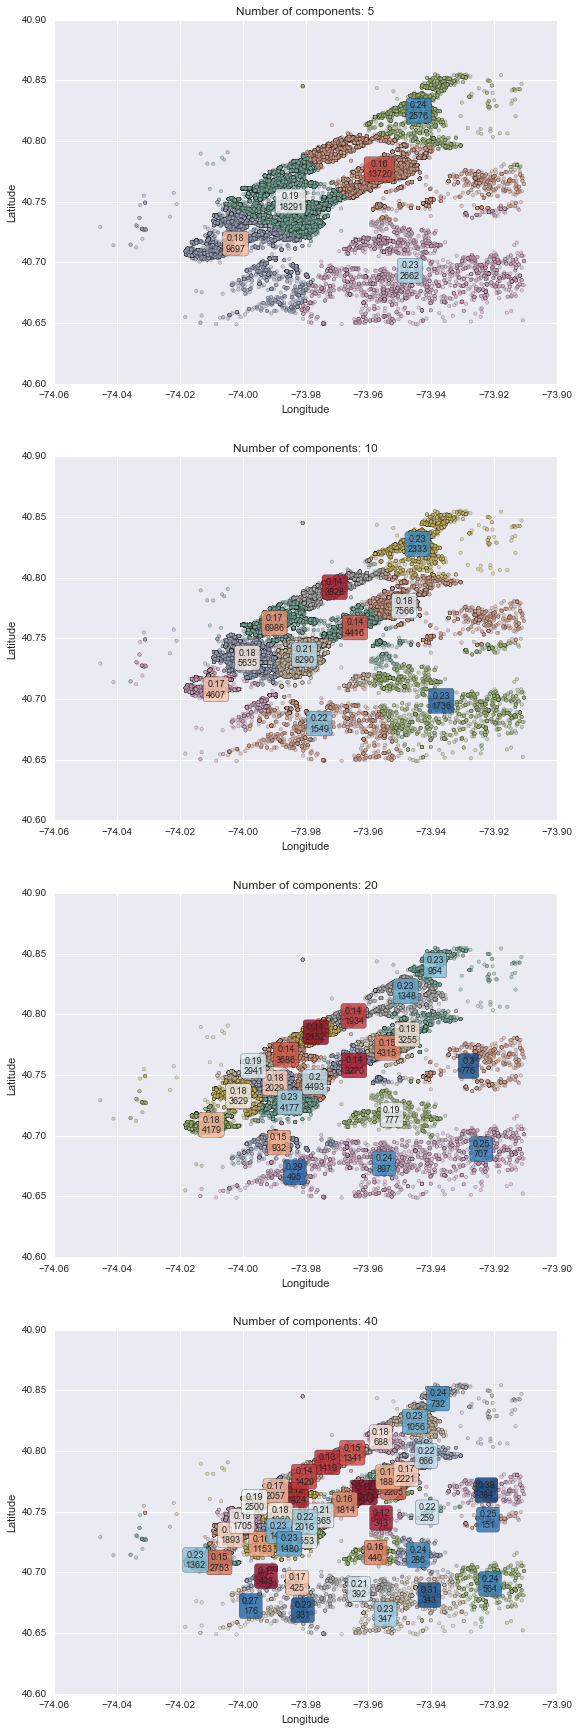

In [93]:
fig, ax = plt.subplots(4,1,figsize=(9,30))

for ix, ncomp in enumerate([5, 10, 20, 40]): 
    r = KMeans(ncomp, random_state=1)
    
    # Normalize longitude, latitude
    temp = train_df[['longitude', 'latitude']].copy()
    temp['longitude'] = (temp['longitude']-temp['longitude'].mean())/temp['longitude'].std()
    temp['latitude'] = (temp['latitude']-temp['latitude'].mean())/temp['latitude'].std()
    
    # Fit k-means and get labels
    r.fit(temp[['longitude', 'latitude']])
    train_df['labels'] = r.labels_
    
    # Plot results
    cols = sns.color_palette("Set2", n_colors=ncomp, desat=0.5)
    cl = [cols[i] for i in r.labels_]
    area = 12
    ax[ix].scatter(train_df.longitude, train_df.latitude, s=area, c=cl, alpha=0.5);
    ax[ix].set_title('Number of components: ' + str(ncomp))
    ax[ix].set_xlabel('Longitude')
    ax[ix].set_ylabel('Latitude')
    
    # Show aggregated volume and interest at each neighborhood
    x = train_df.groupby('labels')[['longitude','latitude','interest_level']].mean().sort_values(['interest_level'])
    x = pd.concat([x, train_df['labels'].value_counts()], axis=1).sort_values(['interest_level'])
    cols = sns.color_palette("RdBu_r", ncomp)[::-1]
    
    for i in range(ncomp):
        props = dict(boxstyle='round', facecolor=cols[i], alpha=0.8)
        ax[ix].text(x.longitude.values[i], x.latitude.values[i], 
                str(np.array(np.round(x.interest_level.values,2), '|S8')[i])+'\n'+str(np.array(x['labels'].values, '|S8')[i]), 
                fontsize=9, verticalalignment='center', horizontalalignment='center', bbox=props);

In [108]:
# find centroids of 5 boroughs
# need to normalize lon, lat
k = KMeans(n_clusters=5, random_state=1)
k.fit(train_df[['longitude', 'latitude']])
k.cluster_centers_

array([[-73.98356655,  40.75323318],
       [-73.94459474,  40.82751759],
       [-73.95648445,  40.77901614],
       [-73.99855045,  40.71993652],
       [-73.95348287,  40.688674  ]])